# **Import the packages**

In [2]:
!pip install higher
import numpy as np
import pandas as pd
import higher
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import itertools
from tqdm.notebook import tqdm
from torch import autograd




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Fuctions to generate imbalanced train datasets, balanced test dataset and clean dataset**

In [3]:
args = {'batch_size':100, 'lr':0.001, 'n_epochs':100, 'device':torch.device("cuda" if torch.cuda.is_available() else "cpu")}

In [4]:
def get_clean_dataset(testset, set_size = 0.002):
  #split cat and dog datasets
  train_cat_idxs = np.where(np.array(testset.targets) == 3)[0] 
  train_dog_idxs = np.where(np.array(testset.targets) == 5)[0] 
  total_cats = len(train_cat_idxs) #5000
  total_dogs = len(train_dog_idxs) #5000
  num_of_cats = int(total_cats*set_size)
  num_of_dogs = int(total_dogs*set_size)
  #clean data set
  clean_idxs = np.concatenate([train_cat_idxs[:num_of_cats], train_dog_idxs[:num_of_dogs]])
  clean_dataset = torch.utils.data.Subset(testset,clean_idxs)
  clean_loader = torch.utils.data.DataLoader(clean_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=2)
  return clean_loader
def get_imbalanced_datasets(trainset,imbalance_ratio):  #ratio = cats/dogs
  #split cat and dog datasets
  train_cat_idxs = np.where(np.array(trainset.targets) == 3)[0] 
  train_dog_idxs = np.where(np.array(trainset.targets) == 5)[0] 
  total_cats = len(train_cat_idxs) #5000
  total_dogs = len(train_dog_idxs) #5000
  #Imbalanced dataset
  num_of_cats = int(total_cats*imbalance_ratio)
  imbl_train_idxs = np.concatenate([train_cat_idxs[:num_of_cats], train_dog_idxs[:total_dogs]])
  imbl_train_dataset = torch.utils.data.Subset(trainset,imbl_train_idxs)
  data_loader = torch.utils.data.DataLoader(imbl_train_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=2)
  return data_loader

def get_balanced_datasets(testset):
  test_cat_idxs = np.where(np.array(testset.targets) == 3)[0] 
  test_dog_idxs = np.where(np.array(testset.targets) == 5)[0]   
  total_cats = len(test_cat_idxs) #5000
  total_dogs = len(test_dog_idxs) #5000
  #balanced dataset
  test_idxs = np.concatenate([test_cat_idxs[:total_cats], test_dog_idxs[:total_dogs]])
  test_dataset = torch.utils.data.Subset(testset,test_idxs)
  data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=2)
  return data_loader



# **Helper Functions**

In [5]:
class LeNet5(torch.nn.Module):          
    def __init__(self):     
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2) 
        self.fc1 = torch.nn.Linear(16*6*6, 120)   
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 6)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))  
        x = self.max_pool_1(x) 
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = x.view(-1, 16*6*6)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x).squeeze()
        return x

In [6]:
def accuracy(network, dataloader):
  network.eval()
  total_correct = 0
  total_instances = 0
  for  _, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device = args['device'], non_blocking=True), labels.to(device = args['device'], non_blocking=True)
    predictions = torch.argmax(network(images), dim=1)
    correct_predictions = sum(predictions==labels).item()
    total_correct+=correct_predictions
    total_instances+=len(images)
  return round(total_correct/total_instances, 3)

In [7]:

def train_base_model(model, criterion, optimizer, train_loader):
  loss_track = []
  accuracy_track = []
  for i in tqdm(range(1, args['n_epochs']+1)):
    model.train()
    accu = 0
    loss = 0
    correct = 0
    sum = 0
    for _, (images, labels) in enumerate(train_loader):
      images,labels = images.to(device = args['device'], non_blocking=True),labels.to(device = args['device'], non_blocking=True)
      outputs = model(images)
      optimizer.zero_grad()
      training_loss = criterion(outputs, labels)
      training_loss.backward()
      optimizer.step()
      loss += training_loss.item()*outputs.shape[0]
    loss_track.append(loss/(len(train_loader)*100))
    
    #evaluating
    model.eval()
    with torch.no_grad():
        train_accu = accuracy(model, train_loader)
        accuracy_track.append(train_accu)
    print('Training Loss:', loss/(len(train_loader)*100), 'Training Accuracy:', train_accu)
  return loss_track, accuracy_track




In [8]:
def base_model(model, criterion, optimizer, train_loader, test_loader):
  train_loss_track = []
  train_accuracy_track = []
  test_loss_track = []
  test_accuracy_track = []
  for i in tqdm(range(1, args['n_epochs']+1)):
    model.train()
    tr_accu = 0
    accu = 0
    tr_loss = 0
    loss = 0
    correct = 0
    sum = 0
    for _, (images, labels) in enumerate(train_loader):
      images,labels = images.to(device = args['device'], non_blocking=True),labels.to(device = args['device'], non_blocking=True)
      outputs = model(images)
      optimizer.zero_grad()
      training_loss = criterion(outputs, labels)
      training_loss.backward()
      optimizer.step()
      loss += training_loss.item()*outputs.shape[0]
      _, predicted = torch.max(outputs.data, 1)
      correct += predicted.eq(labels.data).cpu().sum()
    tr_loss = loss/len(train_loader.dataset)
    tr_accu = correct.numpy() / len(train_loader.dataset)
    train_loss_track.append(tr_loss)
    train_accuracy_track.append(tr_accu)
    
    #Test evaluating
    model.eval()
    criterion.reduction = 'mean'
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device = args['device']), targets.to(device = args['device'])
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * outputs.shape[0]
            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(targets.data).cpu().sum()
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct.numpy() / len(test_loader.dataset)
    test_loss_track.append(epoch_loss)
    test_accuracy_track.append(epoch_acc)
    print('Training Loss:', tr_loss, 'Training Accuracy:', tr_accu,'Testing Loss:', epoch_loss, 'Testing Accuracy:', epoch_acc)
  return train_loss_track, train_accuracy_track, test_loss_track, test_accuracy_track


In [9]:

def train_model_reweighting(model, criterion, optimizer, train_loader, clean_loader):
    loss_track = []
    accuracy_track = []
    for i in tqdm(range(1, args['n_epochs']+1)):
        model.train()
        loss = 0
        # Step 2: Sample mini-batch from Df
        for _, (images,labels) in enumerate(train_loader):
          images,labels = images.to(device = args['device'], non_blocking=True),labels.to(device = args['device'], non_blocking=True)
          optimizer.zero_grad()
          
          with higher.innerloop_ctx(model, optimizer) as (clean_model, clean_optimizer):
            # Step 1. Update meta model on training data
            ctrain_outputs = clean_model(images)
            criterion.reduction = 'none'
            ctrain_loss = criterion(ctrain_outputs, labels)
            eps = torch.zeros(ctrain_loss.size(), requires_grad=True, device=args['device'])
            ctrain_loss = torch.sum(eps * ctrain_loss)
            clean_optimizer.step(ctrain_loss)

            # Step 2. Compute grads of eps on meta validation data
            clean_images, clean_labels =  next(clean_loader)
            #meta_labels =meta_labels.unsqueeze(1)  
            clean_images, clean_labels = clean_images.to(device=args['device'], non_blocking=True),\
                            clean_labels.to(device=args['device'], non_blocking=True)

            clean_val_outputs = clean_model(clean_images)
            criterion.reduction = 'mean'
            clean_val_loss = criterion(clean_val_outputs, clean_labels)
            eps_grads = torch.autograd.grad(clean_val_loss, eps)[0].detach()
          # Step 3:
          w_hat = torch.clamp(-eps_grads, min = 0)
          sum = torch.sum(w_hat)
          if (sum == 0):
            weight = w_hat
          else:
            weight = w_hat/sum

          # Step 4: Forward pass on Xf with current theta
          y_hat_f = model(images)
          criterion.reduction = 'none'
          mloss = criterion(y_hat_f, labels)
          minib_loss = torch.sum(mloss*weight)

          optimizer.zero_grad()
          minib_loss.backward()
          optimizer.step()

          loss += minib_loss.item()*y_hat_f.shape[0]
        loss_track.append(loss/(len(train_loader)*100))
        model.eval()
        with torch.no_grad():
          train_accu = accuracy(model, train_loader)
          accuracy_track.append(train_accu)
        print('Training Loss:', loss/(len(train_loader)*100), 'Training Accuracy:', train_accu)
    return loss_track, accuracy_track

In [10]:
def model_reweighting(model, criterion, optimizer, train_loader, clean_loader, test_loader):
      train_loss_track = []
      train_accuracy_track = []
      test_loss_track = []
      test_accuracy_track = []
      for i in tqdm(range(1, args['n_epochs']+1)):
        model.train()
        tr_accu = 0
        accu = 0
        tr_loss = 0
        loss = 0
        correct = 0
        sum = 0
        # Step 2: Sample mini-batch from Df
        for _, (images,labels) in enumerate(train_loader):
          images,labels = images.to(device = args['device'], non_blocking=True),labels.to(device = args['device'], non_blocking=True)
          optimizer.zero_grad()
          
          with higher.innerloop_ctx(model, optimizer) as (clean_model, clean_optimizer):
            # Step 1. Update meta model on training data
            ctrain_outputs = clean_model(images)
            criterion.reduction = 'none'
            ctrain_loss = criterion(ctrain_outputs, labels)
            eps = torch.zeros(ctrain_loss.size(), requires_grad=True, device=args['device'])
            ctrain_loss = torch.sum(eps * ctrain_loss)
            clean_optimizer.step(ctrain_loss)

            # Step 2. Compute grads of eps on meta validation data
            clean_images, clean_labels =  next(clean_loader)
            #meta_labels =meta_labels.unsqueeze(1)  
            clean_images, clean_labels = clean_images.to(device=args['device'], non_blocking=True),\
                            clean_labels.to(device=args['device'], non_blocking=True)

            clean_val_outputs = clean_model(clean_images)
            criterion.reduction = 'mean'
            clean_val_loss = criterion(clean_val_outputs, clean_labels)
            eps_grads = torch.autograd.grad(clean_val_loss, eps)[0].detach()
          # Step 3:
          w_hat = torch.clamp(-eps_grads, min = 0)
          sum = torch.sum(w_hat)
          if (sum == 0):
            weight = w_hat
          else:
            weight = w_hat/sum


          y_hat_f = model(images)
          criterion.reduction = 'none'
          mloss = criterion(y_hat_f, labels)
          minib_loss = torch.sum(mloss*weight)

          optimizer.zero_grad()
          minib_loss.backward()
          optimizer.step()

          loss += minib_loss.item()*y_hat_f.shape[0]
          _, predicted = torch.max(y_hat_f.data, 1)
          correct += predicted.eq(labels.data).cpu().sum()
        tr_loss = loss/len(train_loader.dataset)
        tr_accu = correct.numpy() / len(train_loader.dataset)
        train_loss_track.append(tr_loss)
        train_accuracy_track.append(tr_accu)
        
        #Test evaluating
        model.eval()
        criterion.reduction = 'mean'
        running_loss = 0.0
        correct = 0
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device = args['device']), targets.to(device = args['device'])
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * outputs.shape[0]
                _, predicted = torch.max(outputs.data, 1)
                correct += predicted.eq(targets.data).cpu().sum()
        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = correct.numpy() / len(test_loader.dataset)
        test_loss_track.append(epoch_loss)
        test_accuracy_track.append(epoch_acc)
        print('Training Loss:', tr_loss, 'Training Accuracy:', tr_accu,'Testing Loss:', epoch_loss, 'Testing Accuracy:', epoch_acc)
      return train_loss_track, train_accuracy_track, test_loss_track, test_accuracy_track

In [11]:
def test_model0(model, criterion, test_loader):
    test_loss_hist = []
    test_accu_hist = []
    total = 0
    for i in tqdm(range(1, args['n_epochs']+1)):
      model.eval()  # Set the model to evaluation mode
      loss = 0

      correct = 0
      with torch.no_grad():
          for  _, (images,labels) in enumerate(test_loader):
            images,labels = images.to(device = args['device']),labels.to(device = args['device'])
            predict = model(images)
            testing_loss = criterion(predict, labels)
            loss += testing_loss.item() * predict.shape[0]
            _, predicted = torch.max(predict.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
      test_loss_hist.append(loss/len(test_loader))
      #test_accu = accuracy(model, test_loader)
      test_accu_hist.append(correct/len(test_loader))

      print('Training Loss:', loss/len(test_loader), 'Training Accuracy:', correct/len(test_loader))
    return test_loss_hist, test_accu_hist

In [12]:
def test_model(model, criterion, test_loader):
  loss_track = []
  accuracy_track = []
  for i in tqdm(range(1, args['n_epochs']+1)):
    model.train()
    accu = 0
    loss = 0
    correct = 0
    sum = 0
    for _, (images, labels) in enumerate(test_loader):
      images,labels = images.to(device = args['device'], non_blocking=True),labels.to(device = args['device'], non_blocking=True)
      outputs = model(images)
      training_loss = criterion(outputs, labels)
      training_loss.backward()
      loss += training_loss.item()*outputs.shape[0]
    loss_track.append(loss/(len(test_loader)*100))
    model.eval()
    with torch.no_grad():
        train_accu = accuracy(model, test_loader)
        accuracy_track.append(train_accu)
    print('Testing Loss:', loss/(len(test_loader)*100), 'Testing Accuracy:', train_accu)
  return loss_track, accuracy_track

## **Main**

Laoding the datasets and split it

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = args['batch_size']
#load the train dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#load train dataset, imbalanced dataset
imbl_train_loader  = get_imbalanced_datasets(trainset, 0.995)

#load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = get_balanced_datasets(testset)


100%|██████████| 170498071/170498071 [00:03<00:00, 53857803.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Training a base model

In [14]:
model = LeNet5()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'])

#training baseline
#loss_hist, accu_hist = train_base_model(model, criterion, optimizer, imbl_train_loader)
bs_tr_loss_hist, bs_tr_accu_hist, bs_ts_loss_hist, bs_ts_accu_hist = base_model(model, criterion, optimizer, imbl_train_loader, test_loader)


  0%|          | 0/100 [00:00<?, ?it/s]

Training Loss: 1.757054269164427 Training Accuracy: 0.41102756892230574 Testing Loss: 1.7344996809959412 Testing Accuracy: 0.5
Training Loss: 1.7126002670230722 Training Accuracy: 0.5012531328320802 Testing Loss: 1.6904305040836334 Testing Accuracy: 0.5
Training Loss: 1.6686905798756688 Training Accuracy: 0.5012531328320802 Testing Loss: 1.6466549396514893 Testing Accuracy: 0.5
Training Loss: 1.6247329732827973 Training Accuracy: 0.5012531328320802 Testing Loss: 1.602248454093933 Testing Accuracy: 0.5
Training Loss: 1.5789947372331357 Training Accuracy: 0.5012531328320802 Testing Loss: 1.5545254528522492 Testing Accuracy: 0.5
Training Loss: 1.5273073143827587 Training Accuracy: 0.5012531328320802 Testing Loss: 1.4974064230918884 Testing Accuracy: 0.5
Training Loss: 1.460488524353295 Training Accuracy: 0.5012531328320802 Testing Loss: 1.4178481221199035 Testing Accuracy: 0.5
Training Loss: 1.3588388208159827 Training Accuracy: 0.5019548872180452 Testing Loss: 1.2870293319225312 Testing 

Training a reweight model

In [16]:
#traning reweight model
rw_model = LeNet5()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rw_model.parameters(), lr=args['lr'])
#load train dataset, imbalanced dataset
imbl_train_loader  = get_imbalanced_datasets(trainset, 0.995)

#load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = get_balanced_datasets(testset)

#load clean data set
clean_loader = get_clean_dataset(trainset)
clean_loader = itertools.cycle(clean_loader)
#load test data set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = get_balanced_datasets(testset)
#traning
rw_tr_loss_hist, rw_tr_accu_hist, rw_ts_loss_hist, rw_ts_accu_hist = model_reweighting(rw_model, criterion, optimizer, imbl_train_loader, clean_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

Training Loss: 1.7657428621349478 Training Accuracy: 0.4220551378446115 Testing Loss: 1.739209884405136 Testing Accuracy: 0.5
Training Loss: 1.7070182457304837 Training Accuracy: 0.49874686716791977 Testing Loss: 1.681116956472397 Testing Accuracy: 0.5
Training Loss: 1.647830509601679 Training Accuracy: 0.49874686716791977 Testing Loss: 1.620662021636963 Testing Accuracy: 0.5
Training Loss: 1.5828428005514885 Training Accuracy: 0.49874686716791977 Testing Loss: 1.5510559678077698 Testing Accuracy: 0.5
Training Loss: 1.500017067543546 Training Accuracy: 0.49874686716791977 Testing Loss: 1.4570285558700562 Testing Accuracy: 0.5
Training Loss: 1.377301217320569 Training Accuracy: 0.49874686716791977 Testing Loss: 1.3054332911968232 Testing Accuracy: 0.5
Training Loss: 1.186871169802539 Training Accuracy: 0.49874686716791977 Testing Loss: 1.069285625219345 Testing Accuracy: 0.5
Training Loss: 0.9603867547255112 Training Accuracy: 0.5049624060150376 Testing Loss: 0.8580729693174363 Testing 

Plot the figures

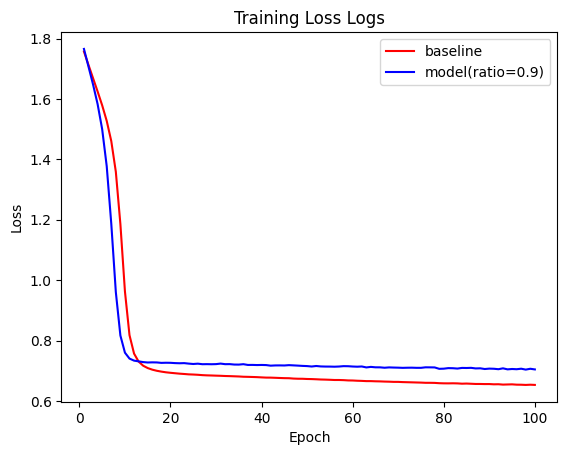

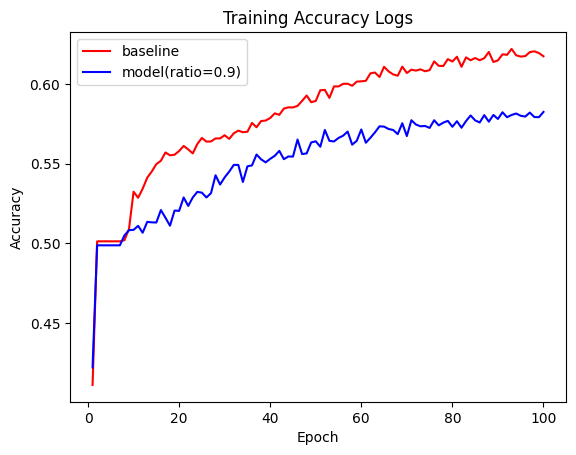

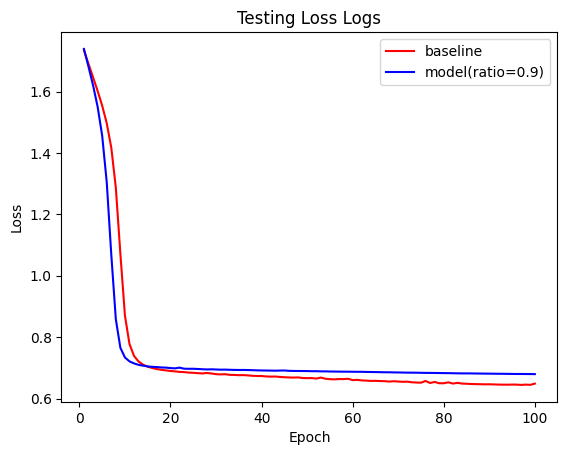

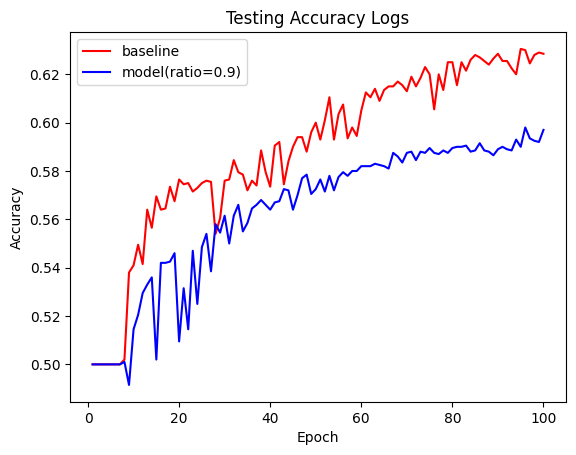

In [17]:
#trainning logs--------------------------------------------
# Plot the loss history
rg = np.linspace(1,len(bs_tr_loss_hist),len(bs_tr_loss_hist))
plt.plot(rg, bs_tr_loss_hist, 'r', label='baseline')
plt.plot(rg, rw_tr_loss_hist, 'b', label='model(ratio=0.9)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Logs')
plt.legend()
plt.show()

# Plot the accuracy history
rg = np.linspace(1,len(bs_tr_accu_hist),len(bs_tr_accu_hist))
plt.plot(rg, bs_tr_accu_hist, 'r', label='baseline')
plt.plot(rg, rw_tr_accu_hist, 'b', label='model(ratio=0.9)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Logs')
plt.legend()
plt.show()

#Testing logs----------------------------------------------
# Plot the loss history
rg = np.linspace(1,len(bs_ts_loss_hist),len(bs_ts_loss_hist))
plt.plot(rg, bs_ts_loss_hist, 'r', label='baseline')
plt.plot(rg, rw_ts_loss_hist, 'b', label='model(ratio=0.9)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Testing Loss Logs')
plt.legend()
plt.show()

# Plot the accuracy history
rg = np.linspace(1,len(bs_ts_accu_hist),len(bs_ts_accu_hist))
plt.plot(rg, bs_ts_accu_hist, 'r', label='baseline')
plt.plot(rg, rw_ts_accu_hist, 'b', label='model(ratio=0.9)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy Logs')
plt.legend()
plt.show()

Train models on different imbalanced ratio dataset

In [95]:
args = {'batch_size':100, 'lr':0.006, 'n_epochs':15, 'device':torch.device("cuda" if torch.cuda.is_available() else "cpu")}
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = args['batch_size']
#load the train dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

ratios = [0.9, 0.95, 0.98, 0.99, 0.995]

base_accu = []
rw_accu = []
for r in ratios:
  #load train dataset, imbalanced dataset
  imbl_train_loader  = get_imbalanced_datasets(trainset, r)

  #load the test dataset
  test_loader = get_balanced_datasets(testset)

  #define model
  model = LeNet5()
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'])

  #training baseline
  bs_tr_loss_hist, bs_tr_accu_hist, bs_ts_loss_hist, bs_ts_accu_hist = base_model(model, criterion, optimizer, imbl_train_loader, test_loader)

  base_accu.append(sum(bs_ts_accu_hist)/len(bs_ts_accu_hist))  #store avg base accu

  #train rewright model
  rw_model = LeNet5()
  rw_criterion = torch.nn.CrossEntropyLoss()
  rw_optimizer = torch.optim.SGD(rw_model.parameters(), lr=args['lr'])
  #load clean data set
  clean_loader = get_clean_dataset(trainset)
  clean_loader = itertools.cycle(clean_loader)
  #load test data set
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
  test_loader = get_balanced_datasets(testset)
  #traning
  rw_tr_loss_hist, rw_tr_accu_hist, rw_ts_loss_hist, rw_ts_accu_hist = model_reweighting(rw_model, rw_criterion, rw_optimizer, imbl_train_loader, clean_loader, test_loader)

  rw_accu.append(sum(rw_ts_accu_hist)/len(rw_ts_accu_hist))  #store avg base accu


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6924482621644672 Training Accuracy: 0.4244210526315789 Testing Loss: 1.5369215846061706 Testing Accuracy: 0.5
Training Loss: 1.1450391116895173 Training Accuracy: 0.5262105263157895 Testing Loss: 0.7528253853321075 Testing Accuracy: 0.5
Training Loss: 0.7146557789099844 Training Accuracy: 0.5236842105263158 Testing Loss: 0.7011288076639175 Testing Accuracy: 0.499
Training Loss: 0.696983824278179 Training Accuracy: 0.5243157894736842 Testing Loss: 0.6940411448478698 Testing Accuracy: 0.5115
Training Loss: 0.6922117427775735 Training Accuracy: 0.5431578947368421 Testing Loss: 0.6902789533138275 Testing Accuracy: 0.5245
Training Loss: 0.6902367384810196 Training Accuracy: 0.5376842105263158 Testing Loss: 0.6866660445928574 Testing Accuracy: 0.545
Training Loss: 0.6870758577396995 Training Accuracy: 0.5512631578947368 Testing Loss: 0.6835164427757263 Testing Accuracy: 0.5795
Training Loss: 0.6849690387123509 Training Accuracy: 0.5526315789473685 Testing Loss: 0.69367855787

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.653355780400728 Training Accuracy: 0.4848421052631579 Testing Loss: 1.5203974664211273 Testing Accuracy: 0.5
Training Loss: 1.3050803473121242 Training Accuracy: 0.5262105263157895 Testing Loss: 0.9529122322797775 Testing Accuracy: 0.499
Training Loss: 0.830511536723689 Training Accuracy: 0.49326315789473685 Testing Loss: 0.7267085433006286 Testing Accuracy: 0.5
Training Loss: 0.8013502993081746 Training Accuracy: 0.4926315789473684 Testing Loss: 0.7175668984651565 Testing Accuracy: 0.4995
Training Loss: 0.7874138116836548 Training Accuracy: 0.502 Testing Loss: 0.7129233300685882 Testing Accuracy: 0.5
Training Loss: 0.7776091669735156 Training Accuracy: 0.4976842105263158 Testing Loss: 0.7094666928052902 Testing Accuracy: 0.5015
Training Loss: 0.7707129629034745 Training Accuracy: 0.4928421052631579 Testing Loss: 0.707404163479805 Testing Accuracy: 0.5
Training Loss: 0.7654887782899957 Training Accuracy: 0.4996842105263158 Testing Loss: 0.7059253841638565 Testing Accur

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6661016189135038 Training Accuracy: 0.3788717948717949 Testing Loss: 1.3791386842727662 Testing Accuracy: 0.514
Training Loss: 0.8817705970544082 Training Accuracy: 0.5177435897435897 Testing Loss: 0.7116536885499954 Testing Accuracy: 0.5
Training Loss: 0.6995425520799099 Training Accuracy: 0.5322051282051282 Testing Loss: 0.6962594777345658 Testing Accuracy: 0.5
Training Loss: 0.6909450955879994 Training Accuracy: 0.5495384615384615 Testing Loss: 0.6891685485839844 Testing Accuracy: 0.5095
Training Loss: 0.6871064302248833 Training Accuracy: 0.5546666666666666 Testing Loss: 0.6825527757406235 Testing Accuracy: 0.546
Training Loss: 0.6827180400872842 Training Accuracy: 0.5687179487179487 Testing Loss: 0.6749172180891037 Testing Accuracy: 0.6115
Training Loss: 0.6793563506542108 Training Accuracy: 0.5714871794871795 Testing Loss: 0.6847517699003219 Testing Accuracy: 0.5165
Training Loss: 0.6767197599777809 Training Accuracy: 0.5788717948717949 Testing Loss: 0.6707178264

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.5161509440495418 Training Accuracy: 0.5032820512820513 Testing Loss: 1.0214179635047913 Testing Accuracy: 0.5
Training Loss: 0.8719583303500444 Training Accuracy: 0.4926153846153846 Testing Loss: 0.7356662392616272 Testing Accuracy: 0.5
Training Loss: 0.8233527284402113 Training Accuracy: 0.5055384615384615 Testing Loss: 0.7201367259025574 Testing Accuracy: 0.5
Training Loss: 0.8008375925895496 Training Accuracy: 0.5024615384615385 Testing Loss: 0.7147749364376068 Testing Accuracy: 0.5
Training Loss: 0.7864855475914784 Training Accuracy: 0.5123076923076924 Testing Loss: 0.7100613623857498 Testing Accuracy: 0.5
Training Loss: 0.7782538034977057 Training Accuracy: 0.5014358974358974 Testing Loss: 0.7071227073669434 Testing Accuracy: 0.5
Training Loss: 0.7714367435528682 Training Accuracy: 0.5123076923076924 Testing Loss: 0.7053374409675598 Testing Accuracy: 0.5
Training Loss: 0.7666644677137717 Training Accuracy: 0.5056410256410256 Testing Loss: 0.7033288896083831 Testin

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6559292090059532 Training Accuracy: 0.494949494949495 Testing Loss: 1.5299442052841186 Testing Accuracy: 0.5
Training Loss: 1.377899013384424 Training Accuracy: 0.494949494949495 Testing Loss: 1.1420677125453949 Testing Accuracy: 0.496
Training Loss: 0.8382531476743293 Training Accuracy: 0.5058585858585859 Testing Loss: 0.7180006772279739 Testing Accuracy: 0.523
Training Loss: 0.7065063450071547 Training Accuracy: 0.5151515151515151 Testing Loss: 0.7021076917648316 Testing Accuracy: 0.501
Training Loss: 0.6965699599246786 Training Accuracy: 0.5293939393939394 Testing Loss: 0.6932192623615265 Testing Accuracy: 0.5575
Training Loss: 0.6939677638236923 Training Accuracy: 0.5294949494949495 Testing Loss: 0.6953198581933975 Testing Accuracy: 0.5015
Training Loss: 0.690581581809304 Training Accuracy: 0.5378787878787878 Testing Loss: 0.6878162503242493 Testing Accuracy: 0.561
Training Loss: 0.6890173355738322 Training Accuracy: 0.5448484848484848 Testing Loss: 0.6844637781381

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6615882148646346 Training Accuracy: 0.494949494949495 Testing Loss: 1.5576681792736053 Testing Accuracy: 0.5
Training Loss: 1.469145336536446 Training Accuracy: 0.5068686868686869 Testing Loss: 1.3784973978996278 Testing Accuracy: 0.511
Training Loss: 1.2566319595683704 Training Accuracy: 0.5061616161616161 Testing Loss: 1.0975062787532806 Testing Accuracy: 0.5
Training Loss: 0.898633953898844 Training Accuracy: 0.5061616161616161 Testing Loss: 0.7483959466218948 Testing Accuracy: 0.5
Training Loss: 0.8011528548568186 Training Accuracy: 0.5022222222222222 Testing Loss: 0.7167426526546479 Testing Accuracy: 0.5
Training Loss: 0.7830273310343424 Training Accuracy: 0.4952525252525253 Testing Loss: 0.7135655224323273 Testing Accuracy: 0.5
Training Loss: 0.7714659993094627 Training Accuracy: 0.5073737373737374 Testing Loss: 0.7081520974636077 Testing Accuracy: 0.5
Training Loss: 0.765041688475946 Training Accuracy: 0.5040404040404041 Testing Loss: 0.7086185961961746 Testing 

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6731653716695967 Training Accuracy: 0.41035175879396985 Testing Loss: 1.4958527863025666 Testing Accuracy: 0.5
Training Loss: 1.041928651344836 Training Accuracy: 0.5072361809045226 Testing Loss: 0.731226122379303 Testing Accuracy: 0.526
Training Loss: 0.7102265351980774 Training Accuracy: 0.5241206030150753 Testing Loss: 0.6975997567176819 Testing Accuracy: 0.55
Training Loss: 0.6958564277270332 Training Accuracy: 0.532964824120603 Testing Loss: 0.6937403380870819 Testing Accuracy: 0.541
Training Loss: 0.6925756200474111 Training Accuracy: 0.5320603015075377 Testing Loss: 0.6912393778562546 Testing Accuracy: 0.5485
Training Loss: 0.6889215111732483 Training Accuracy: 0.542713567839196 Testing Loss: 0.6838763266801834 Testing Accuracy: 0.564
Training Loss: 0.6883027203118981 Training Accuracy: 0.5433165829145729 Testing Loss: 0.7279685854911804 Testing Accuracy: 0.5
Training Loss: 0.6863212980816712 Training Accuracy: 0.5488442211055277 Testing Loss: 0.6804077178239822

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.7364139526932683 Training Accuracy: 0.3064321608040201 Testing Loss: 1.6077714204788207 Testing Accuracy: 0.5
Training Loss: 1.4632470038667995 Training Accuracy: 0.5010050251256282 Testing Loss: 1.2491835713386537 Testing Accuracy: 0.5025
Training Loss: 0.9209746990970631 Training Accuracy: 0.5005025125628141 Testing Loss: 0.7477432578802109 Testing Accuracy: 0.5
Training Loss: 0.8079102901957143 Training Accuracy: 0.48894472361809044 Testing Loss: 0.7268881469964981 Testing Accuracy: 0.5
Training Loss: 0.7904597727497619 Training Accuracy: 0.4950753768844221 Testing Loss: 0.7155260115861892 Testing Accuracy: 0.5
Training Loss: 0.7785964868775564 Training Accuracy: 0.5093467336683417 Testing Loss: 0.7115123420953751 Testing Accuracy: 0.502
Training Loss: 0.7704572677612305 Training Accuracy: 0.5072361809045226 Testing Loss: 0.7094612061977387 Testing Accuracy: 0.4995
Training Loss: 0.7645051036048774 Training Accuracy: 0.5079396984924623 Testing Loss: 0.70780793130397

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.619764404488088 Training Accuracy: 0.46265664160401004 Testing Loss: 1.4169007658958435 Testing Accuracy: 0.5
Training Loss: 0.954532073703326 Training Accuracy: 0.5030576441102756 Testing Loss: 0.7163123250007629 Testing Accuracy: 0.497
Training Loss: 0.703361797900427 Training Accuracy: 0.5186967418546365 Testing Loss: 0.6951958417892456 Testing Accuracy: 0.5265
Training Loss: 0.6939517290968644 Training Accuracy: 0.533233082706767 Testing Loss: 0.6883134186267853 Testing Accuracy: 0.579
Training Loss: 0.690434600028179 Training Accuracy: 0.5411528822055138 Testing Loss: 0.6893151134252549 Testing Accuracy: 0.523
Training Loss: 0.6857457144517349 Training Accuracy: 0.5525814536340852 Testing Loss: 0.6874501645565033 Testing Accuracy: 0.539
Training Loss: 0.6822558442751566 Training Accuracy: 0.5674185463659148 Testing Loss: 0.6768973678350448 Testing Accuracy: 0.5925
Training Loss: 0.6791598855104661 Training Accuracy: 0.5758395989974937 Testing Loss: 0.6693793982267

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6361367875770818 Training Accuracy: 0.44741854636591477 Testing Loss: 1.4676593363285064 Testing Accuracy: 0.448
Training Loss: 1.0824948358057733 Training Accuracy: 0.49724310776942354 Testing Loss: 0.7497108042240143 Testing Accuracy: 0.5
Training Loss: 0.8217992222398743 Training Accuracy: 0.4957393483709273 Testing Loss: 0.7263901442289352 Testing Accuracy: 0.5
Training Loss: 0.8003766004901781 Training Accuracy: 0.49273182957393485 Testing Loss: 0.7175106257200241 Testing Accuracy: 0.5
Training Loss: 0.7866859071535575 Training Accuracy: 0.4957393483709273 Testing Loss: 0.7126595109701157 Testing Accuracy: 0.5
Training Loss: 0.7775476510662184 Training Accuracy: 0.49353383458646616 Testing Loss: 0.711226025223732 Testing Accuracy: 0.5
Training Loss: 0.7706844630396754 Training Accuracy: 0.5015538847117794 Testing Loss: 0.7092369973659516 Testing Accuracy: 0.5
Training Loss: 0.7652891500850668 Training Accuracy: 0.5075689223057644 Testing Loss: 0.7074067234992981 T

Plot the figure

In [1]:
#plotting the result

plt.plot(ratios, base_accu, 'r', label='baseline')
plt.plot(ratios, rw_accu, 'b', label='our model')
plt.xlabel('Ratio')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy On Different Imbalanced Ratio')
plt.legend()
plt.show()

NameError: ignored